In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

from train import Arguments, train_m_models
from plotter import plot_loss_accs

from gpt import GPT
from data import get_arithmetic_dataset


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

from data import get_arithmetic_dataset
(train_dataset, _), tokenizer, max_length, padding_index = get_arithmetic_dataset(p=31, q=31, operator="+", r_train=0.5, operation_orders=2)
sample_indices = [34, 51]
inputs = torch.stack([train_dataset[i][0] for i in sample_indices]).to(device)

In [3]:
model = GPT(
    num_heads=4,
    num_layers=2,
    embedding_size=128,
    vocabulary_size=len(tokenizer),
    sequence_length=max_length,
    multiplier=4,
    dropout=0.0,
    non_linearity="gelu",
    padding_index=padding_index,
    bias_attention=True,
    bias_classifier=True,
    share_embeddings=False
)

checkpoint_path = "/home/ozhan/IFT6135/IFT6135-2025/IFT6135_W25_A2_release/logs/scaling_data_size/gpt/0.5/0/r_train_0.5_state_10002_acc=1.0_loss=0.0006873990641906857.pth"  # Replace with actual file name
state_dict = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')["model_state_dict"]
model.load_state_dict(state_dict)
model.eval()
model.to(device)



/tmp/ipykernel_1944756/82753644.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available(

GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=True)
          (W_K): Linear(in_features=128, out_features=128, bias=True)
          (W_V): Linear(in_features=128, out_features=128, bias=True)
          (W_O): Linear(in_features=128, out_features=128, bias=True)
        )
        (self_attn_norm): LayerNorm()
        (ffn): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=False)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=False)
        )
        (ffn_drop): Dropout(p=0.0, inplace=False)
        (ffn_norm): LayerNorm()
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=36, bias=True)
)

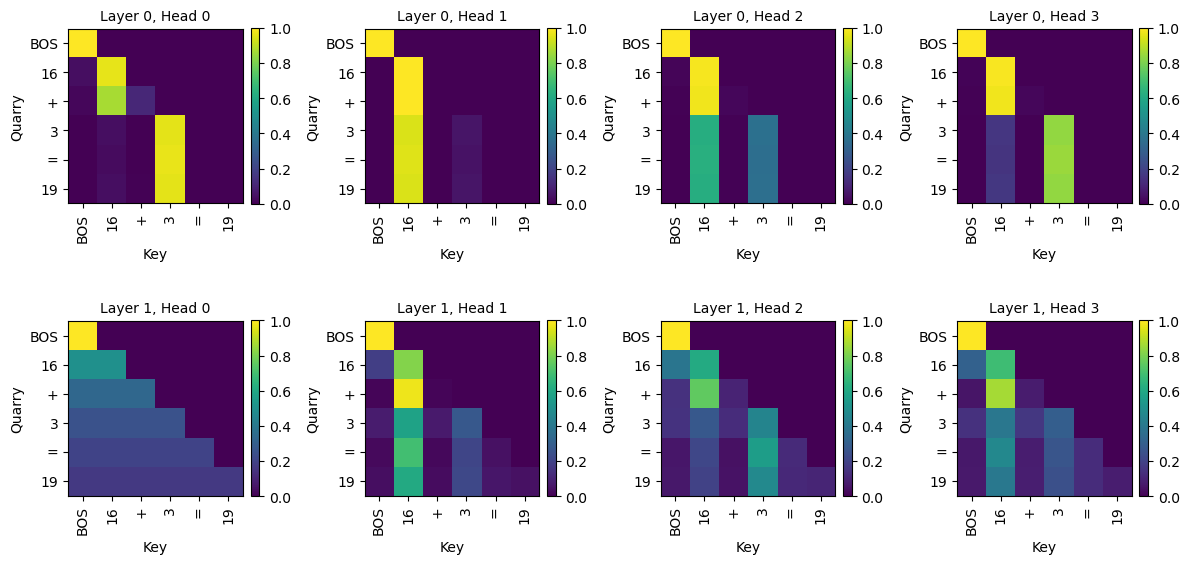

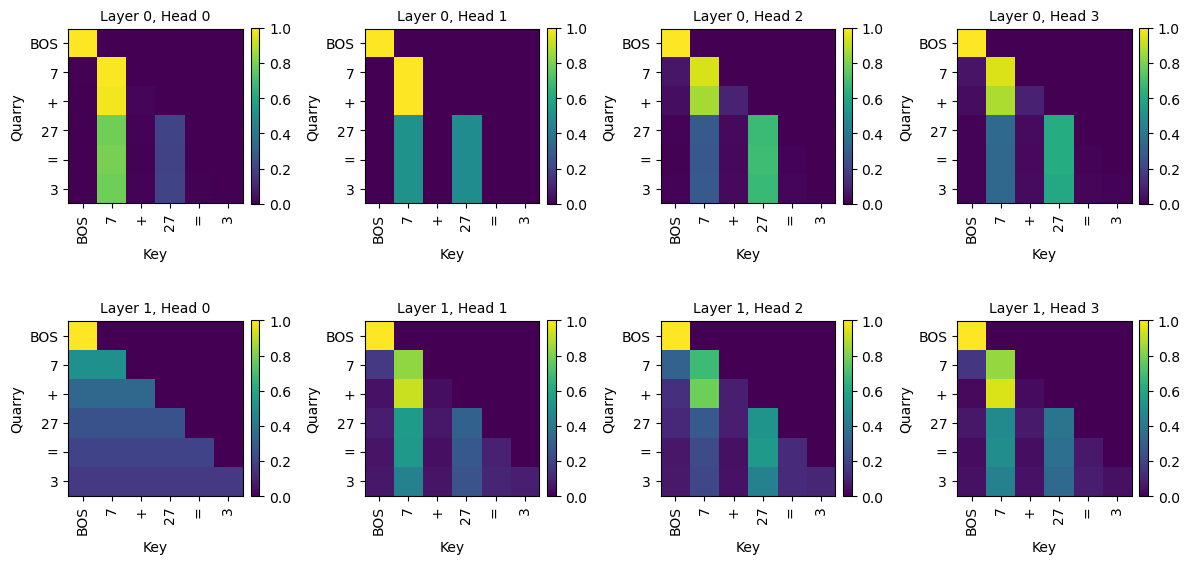

In [ ]:



with torch.no_grad():
    logits, (hidden_states, attentions) = model(inputs)  


def plot_attention(attn, tokens, sample_id, one_indexed=True):
    num_layers, num_heads, S, _ = attn.shape
    fig, axes = plt.subplots(num_layers, num_heads, figsize=(3 * num_heads, 3 * num_layers))

    for i in range(num_layers):
        for j in range(num_heads):
            ax = axes[i, j] if num_layers > 1 else axes[j]
            im = ax.imshow(attn[i, j].cpu(), cmap='viridis', vmin=0, vmax=1)
            layer_label = i  if one_indexed else i
            head_label = j  if one_indexed else j
            ax.set_title(f"Layer {layer_label}, Head {head_label}", fontsize=10)
            ax.set_xticks(range(S))
            ax.set_xlabel('Key')
            ax.set_ylabel('Quarry')

            ax.set_yticks(range(S))
            ax.set_xticklabels(tokens, rotation=90)
            ax.set_yticklabels(tokens)
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.savefig(f'./weights_{sample_id}.png',dpi=300, bbox_inches='tight',format='png')
    plt.show()
for i in range(inputs.shape[0]):
    token_ids = inputs[i]
    token_text = tokenizer.decode(token_ids).split()
    plot_attention(attentions[i], token_text, i)

In [51]:
inputs.shape

torch.Size([2, 6])

In [72]:
predicted_token_ids = torch.argmax(logits, dim=-1)
for i in range(predicted_token_ids.shape[0]):
    input_tokens = [tokenizer.decode(torch.tensor([t.item()])) for t in inputs[i]]
    predicted_tokens = [tokenizer.decode(torch.tensor([t.item()])) for t in predicted_token_ids[i]]

    input_str = ' '.join(input_tokens)
    predicted_str = ' '.join(predicted_tokens)

    print(f"Sample {i}:")
    print(f"  Input:     {input_str}")
    print(f"  Predicted: {predicted_str}")
    print()


Sample 0:
  Input:     BOS 16 + 3 = 19
  Predicted: EOS EOS EOS 10 19 EOS

Sample 1:
  Input:     BOS 7 + 27 = 3
  Predicted: EOS 17 EOS 17 3 EOS

